<a href="https://colab.research.google.com/github/NguyenDuyHoangQN/ann/blob/main/GOLDEN_FACE_RATIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Import the libraries
import os
import numpy as np
import PIL.Image as Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [8]:

base_dir = '/content/drive/MyDrive/face/face_data/'

# Validate that the categories present are what you'd expect
os.listdir(base_dir)

['round', 'oval', 'heart', 'oblong', 'square']

In [9]:
# Set the image side and batch size. Becasue we will be using MobileNetV2, we will set the image size to 224x224. 
# For more information, see: https://keras.io/applications/#mobilenetv2
IMAGE_SIZE = 224  
BATCH_SIZE = 64
NUMBER_OF_LABELS = len(os.listdir(base_dir)) 

# Create data generator with appropriate scaling and train/validation split
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

# Create training dataset
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

# Create validation dataset
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [10]:
# Create labels.txt file, which we will need to export and save for use in our app
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'heart': 0, 'oblong': 1, 'oval': 2, 'round': 3, 'square': 4}


In [69]:
# Set the image shape based on the image size specified above. 
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3) 

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False, 
    weights='imagenet')

# Freeze the base_model
base_model.trainable = False

# Add classification layers on top of the base model
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(NUMBER_OF_LABELS, activation='softmax')
])


# Compile the model. The optimal loss function depends on the type of model you want to build. 
# This article provides a thorough summary: https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# To get a summary of the model, uncomment the line below
#model.summary()

In [70]:
# Train the model. This will likely take a few minutes. Increasing the number of epochs will increase the model training time, and can be tuned for optimal accuracy.  
history = model.fit(
    train_generator, 
    epochs=20, 
    validation_data=val_generator)

Epoch 1/20
7/7 [==============================] - 5s 411ms/step - loss: 4.8899 - accuracy: 0.1950 - val_loss: 3.1130 - val_accuracy: 0.2100
Epoch 2/20
7/7 [==============================] - 2s 247ms/step - loss: 2.0568 - accuracy: 0.2475 - val_loss: 1.5686 - val_accuracy: 0.3000
Epoch 3/20
7/7 [==============================] - 2s 280ms/step - loss: 1.5877 - accuracy: 0.2225 - val_loss: 1.5861 - val_accuracy: 0.2900
Epoch 4/20
7/7 [==============================] - 2s 256ms/step - loss: 1.5492 - accuracy: 0.2800 - val_loss: 1.5535 - val_accuracy: 0.2600
Epoch 5/20
7/7 [==============================] - 2s 261ms/step - loss: 1.5168 - accuracy: 0.3050 - val_loss: 1.5633 - val_accuracy: 0.2500
Epoch 6/20
7/7 [==============================] - 2s 249ms/step - loss: 1.4858 - accuracy: 0.3150 - val_loss: 1.5720 - val_accuracy: 0.3000
Epoch 7/20
7/7 [==============================] - 2s 261ms/step - loss: 1.4557 - accuracy: 0.3375 - val_loss: 1.5636 - val_accuracy: 0.2400
Epoch 8/20
7/7 [====

In [76]:
# Begin the fine-tuning process by allowing training of the base_model
base_model.trainable = True

# This print statement will tell us the number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards. This number must be less than len(base_model.layers)). In this example, we've chosen 100. 
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
  
# Compile the model. Note that we have chosen a different optimizer from previously
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

Number of layers in the base model:  154


In [77]:
# Train the model, fine tuning this time. 
history_fine = model.fit(
    train_generator, 
    epochs=20,
    validation_data=val_generator)

Epoch 1/20
7/7 [==============================] - 6s 420ms/step - loss: 0.6733 - accuracy: 0.7725 - val_loss: 1.8678 - val_accuracy: 0.2100
Epoch 2/20
7/7 [==============================] - 2s 297ms/step - loss: 0.6637 - accuracy: 0.7475 - val_loss: 1.8510 - val_accuracy: 0.2100
Epoch 3/20
7/7 [==============================] - 2s 267ms/step - loss: 0.6668 - accuracy: 0.7400 - val_loss: 1.8305 - val_accuracy: 0.2200
Epoch 4/20
7/7 [==============================] - 2s 256ms/step - loss: 0.6632 - accuracy: 0.7775 - val_loss: 1.8254 - val_accuracy: 0.2300
Epoch 5/20
7/7 [==============================] - 2s 297ms/step - loss: 0.6590 - accuracy: 0.7700 - val_loss: 1.8166 - val_accuracy: 0.2400
Epoch 6/20
7/7 [==============================] - 2s 268ms/step - loss: 0.6581 - accuracy: 0.7775 - val_loss: 1.8208 - val_accuracy: 0.2400
Epoch 7/20
7/7 [==============================] - 2s 264ms/step - loss: 0.6510 - accuracy: 0.7675 - val_loss: 1.8338 - val_accuracy: 0.2300
Epoch 8/20
7/7 [====

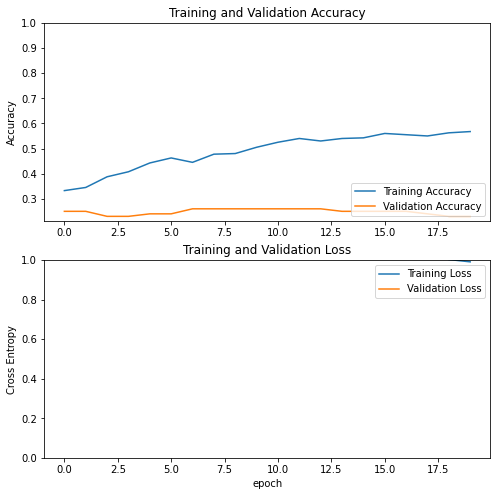

In [66]:
# Plotting accuracy and loss
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
saved_model_dir = 'save/fine_tuning.h5'
model.save(saved_model_dir)

In [4]:
from PIL import Image, ImageDraw
import face_recognition
import scipy.constants
import numpy as np

photo = "/content/drive/MyDrive/train/validation/BINH/BINH20.png"  


# Load the jpg file into a numpy array
image = face_recognition.load_image_file(photo)

# Find all facial features in ll the faces in the image
face_landmarks_list = face_recognition.face_landmarks(
    image)  # (0,0) is upper left corner

if (len(face_landmarks_list)) > 1:
    print("Sorry, there are too many faces in the image. Only use image of one face.")
elif (len(face_landmarks_list)) == 0:
    print("Sorry, no image was detected in the image. Please, try again.")


# Create a PIL imagedraw object so we can draw on the picture
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)

nose_top = []

# extraction of coordinates
lists = []

for face_landmarks in face_landmarks_list:

    # Print the location of each facial feature in this image
    for facial_feature in face_landmarks.keys():
        # first list is chin, 2nd list is left eyebrow, 3rd is right eyebrow, 4th is nose bridge, 5th is nose tip, 6th is left eye, 7th is right eye, 8th is top lip, 9th is bottom lip
        lists.append(face_landmarks[facial_feature])
    n = 0
    # Let's trace out each facial feature in the image with a line!
    for facial_feature in face_landmarks.keys():
        n = n+1
        m = str(n)
        d.point(face_landmarks[facial_feature])

# Show the picture
pil_image.show()

chin = []
left_eyebrow = []
right_eyebrow = []
nose_bridge = []
nose_tip = []
left_eye = []
right_eye = []
top_lip = []
bottom_lip = []

chin.append(lists[0])
left_eyebrow.append(lists[1])
right_eyebrow.append(lists[2])
nose_bridge.append(lists[3])
nose_tip.append(lists[4])
left_eye.append(lists[5])
right_eye.append(lists[6])
top_lip.append(lists[7])
bottom_lip.append(lists[8])

# distance from the top of the nose to the centre of the lips should be 1.618 times the distance
# from the centre of the lips to the chin
# ---> top of nose is the 1st point, centre of lips is the half-way point of the y-component of the 10th point, bottom of chin is the 9th point
(x1, y1) = nose_bridge[0][0]
(x2, y2) = top_lip[0][9]
(x3, y3) = bottom_lip[0][9]
(x4, y4) = chin[0][8]
a = (((y2+y3)/2)-y1)
b = ((y4-((y2+y3)/2)))
# (should equal scipy.constants.golden)
value1 = ((b/a)/(scipy.constants.golden))*100

# length of your face divided by the width of your face
# ---> width can be taken at the cheekbones (1st point and 17th point), length can be taken 1st point of chin and 9th point of chin
(x1, y1) = chin[0][0]
(x2, y2) = chin[0][16]
(x3, y3) = chin[0][8]
a = x2-x1
b = y3-y1
value2 = ((b/a)/scipy.constants.golden)*100


# NOSE: (nose length divided by nose width)/1.618 = percentage score of nose Phi ratio
# if nose ratio smaller than PHi
# ---> nose length = all 5 points on y-axis of nose bridge
# ---> nose width = 5th point of nose tip minus 1st point on x-axis
(x1, y1) = nose_bridge[0][3]
(x2, y2) = nose_tip[0][4]
value3 = ((y1/x2)/(scipy.constants.golden))*100


# EYEBROWS: measure your eyebrow from the end nearest to your nose to the arch in a straight line
# = Arch Length
# ---> use pythagorean theorem, 3rd point, and 5th point
(x1, y1) = left_eyebrow[0][2]
(x2, y2) = left_eyebrow[0][4]
(x3, y3) = right_eyebrow[0][0]
(x4, y4) = right_eyebrow[0][2]
a1 = x2-x1
b1 = y1-y2
a2 = x4-x3
b2 = y3-y4
result1 = np.sqrt((a1**2)+(b1**2))
result2 = np.sqrt((a2**2)+(b2**2))
# measure eyebrow from the same end to the opposite tip in a straight line = full length
# ---> use pythagorean theorem
(x1, y1) = left_eyebrow[0][0]
(x2, y2) = left_eyebrow[0][4]
(x3, y3) = right_eyebrow[0][0]
(x4, y4) = right_eyebrow[0][4]
a1 = x2-x1
b1 = y1-y2
a2 = x4-x3
b2 = y4-y3
result3 = np.sqrt((a1**2)+(b1**2))
result4 = np.sqrt((a2**2)+(b2**2))
# divide full length by arch length = eyebrow ratio ---> arch length/full length since arch length is always lower than full length
value4 = ((result1/result3)/(scipy.constants.golden))*100  # left eyebrow
value5 = ((result2/result4)/(scipy.constants.golden))*100  # right eyebrow


# LIPS: measure the length of the lip from end to end = Lip Length
# Divide Lip Length by Nose Width
(x1, y1) = top_lip[0][0]
(x2, y2) = bottom_lip[0][0]
(x3, y3) = nose_tip[0][0]
(x4, y4) = nose_tip[0][4]
a1 = x2-x1
b1 = x4-x3
value6 = ((b1/a1)/(scipy.constants.golden)) * \
    100  # not included in final measurement


# the distance from the corner of the lip to the opposite edge of the nose should also be
# ---> use pythagorean theorem
# equal to Base of Nose * 1.618
(x1, y1) = top_lip[0][0]
(x2, y2) = nose_tip[0][4]
(x3, y3) = bottom_lip[0][0]
(x4, y4) = nose_tip[0][0]
a1 = x2-x1
b1 = y1-y2
a2 = x3-x4
b2 = y3-y4
c1 = x2-x4
result1 = np.sqrt((a1**2)+(b1**2))
result2 = np.sqrt((a2**2)+(b2**2))
value7 = ((c1/result1)/(scipy.constants.golden))*100
value8 = ((c1/result2)/(scipy.constants.golden))*100

# from the forehead hairline to a spot between the eyes, from between the eyes to the bottom
# of the nose, and from the bottom of the nose to the bottom of the chin, numbers should be equal
# ---> hairline = ????
# ---> 1st nose point to last nose point
# ---> from last nose point to 9th nose point   all y-axis
# (x1,y1)=nose_bridge[0][0]
# (x2,y2)=nose_tip[0][2]
# (x3,y2)=chin[0][8]
# result1=y2-y1
# result2=y3-y2
# value20=(result1-result2)


# length of an ear is equal to the length of the nose, and the width of an eye is equal to the
# distance between eyes
# --->length of ear???
# ---> 1st point and 4th point = width of an eye x-axis
# ---> 4th point of right eye and 1st point of left eye x-axis
(x1, y1) = left_eye[0][0]
(x2, y2) = left_eye[0][3]
(x3, y3) = right_eye[0][0]
(x4, y4) = right_eye[0][3]
a1 = x2-x1
b1 = x4-x3
c1 = x3-x2
# result1=c1-a1
# result2=c1-b1

# distance between eyes divided by the length of the eye should equal phi
# ---> 1st point and 4th point = width of an eye x-axis
# ---> 4th point of right eye and 1st point of left eye x-axis
value9 = ((a1/c1)/(scipy.constants.golden))*100  # left eye
value10 = ((b1/c1)/(scipy.constants.golden))*100  # right eye


# distance from the nose to the edge of the eye, divided by the distance from the edge of the eye
# to the corner of the lips should equal phi
(x1, y1) = nose_tip[0][2]
(x2, y2) = right_eye[0][3]
(x3, y3) = bottom_lip[0][0]
(x4, y4) = top_lip[0][0]
(x5, y5) = left_eye[0][0]
a1 = x2-x1
b1 = y1-y2
result1 = np.sqrt((a1**2)+(b1**2))
a2 = x2-x3
b2 = y3-y2
result2 = np.sqrt((a2**2)+(b2**2))
a3 = x1-x5
b3 = y1-y5
result3 = np.sqrt((a3**2)+(b3**2))
a4 = x4-x5
b4 = y4-y5
result4 = np.sqrt((a4**2)+(b4**2))
value11 = ((result1/result2)/(scipy.constants.golden))*100
value12 = ((result3/result4)/(scipy.constants.golden))*100
# width of lips divided by the length and length of nose divided by the width
# ---> upper: length = 7th point - 1st point on x-axis; width = 4th point - 10th point on y-axis
# ---> lower: length = 1st point - 7th point on x - axis; width = 4th point - 10th point on y-axis
# length
(x1, y1) = top_lip[0][0]
(x2, y2) = top_lip[0][6]
(x3, y3) = bottom_lip[0][6]
(x4, y4) = bottom_lip[0][0]
# width
(x5, y5) = top_lip[0][3]
(x6, y6) = top_lip[0][9]
(x7, y7) = bottom_lip[0][3]
(x8, y8) = bottom_lip[0][9]
a1 = x2-x1
b1 = y6-y5
value13 = ((b1/a1)/(scipy.constants.golden))*100  # unused measurements
a2 = x4-x3
b2 = y7-y8
value14 = ((b1/a1)/(scipy.constants.golden))*100  # unused value

(x9, y9) = nose_tip[0][2]
(x10, y10) = nose_bridge[0][0]
(x11, y11) = nose_tip[0][0]
(x12, y12) = nose_tip[0][4]
a1 = y9-y10
b1 = x12-x11
value15 = ((b1/a1)/(scipy.constants.golden))*100  # unused value

# width of the chin just below the lip should be 1.618 the length of the lip
# -----> width of chin = 13th point - 5th point on x-axis
# ---> length of lip = 1st point - 7th point on x-axis
(x1, y1) = chin[0][7]
(x2, y2) = chin[0][9]
a1 = x2-x1
(x3, y3) = bottom_lip[0][6]
(x4, y4) = bottom_lip[0][0]
b1 = x4-x3
value16 = ((a1/b1)/(scipy.constants.golden))*100

# while calculating the final beauty rating, eyebrows and eyes are considered as one value and not split into right and left, since ratings that include forehead and ears are missing additional points have been removed (a total of 400 points), also the corner of lip/nose ratio is considered to be one, value11 and value12 count as one, value9 and value10 considered as one
finalvalue = ((value1+value2+value3+value4+value5+value6+value7 +
              value8+value9+value10+value11+value12+value16)/600)*100

#
print("")
print("--------------------------------------------------------------------------")

print("The beauty ratio of your nose is....................:", value3, "%")
print("The beauty ratio of your right eyebrow is...........:", value4, "%")
print("The beauty ratio of your left eyebrow is............:", value5, "%")
print("The beauty ratio of your lips is....................:", value6, "%")
print("The beauty ratio of your right eye is...............:", value9, "%")
print("The beauty ratio of your left eye is................:", value10, "%")
print("Congradulations! Your total beauty score is.........:", finalvalue, "%")

print("--------------------------------------------------------------------------")
print("")



Welcome to the facial beauty calculator. This program will perform various calculations on the face in any image you provide based on calculations performed on the face of many beauty models and compare the results to the golden ratio. Please, provide images where the entire face is included. The face in the image should be expressionless and relaxed for best results. Any expressions may change the results.
Results are provided for some individual landmarks and properties of the face. Then a total beauty score is calculated.
Additionally, a comparison between the photo of the face and the computationally generated perfect face is calculated. This comparison is independent of the first measurements.
Please, enjoy!

--------------------------------------------------------------------------
The beauty ratio of your nose is....................: 59.03608250745263 %
The beauty ratio of your right eyebrow is...........: 35.157668928337515 %
The beauty ratio of your left eyebrow is............